# Anime Generation
## DCGAN 

> Data pre-processing [here](https://www.tensorflow.org/tutorials/load_data/images)

In [1]:
import time
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['WANDB_NOTEBOOK_NAME'] = 'Anime Faces and Names'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import winsound
from IPython import display
the_voice = './sounds/chose_a_voice.wav'
the_creation = './sounds/You_created_me.wav'

import tensorflow as tf
# Error: Node: 'sequential_3/dropout_4/dropout/random_uniform/RandomUniform'
# OOM when allocating tensor with shape[256,180,120,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
# 	 [[{{node sequential_3/dropout_4/dropout/random_uniform/RandomUniform}}]]
# the solution to thi is report_tensor_allocations_upon_oom = True
run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom=True)
print("run_opts : => ", run_opts)
runmeta = tf.compat.v1.RunMetadata()
physical_devices = tf.config.list_physical_devices("GPU")
print("physical_devices : => ", physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.distribute.MultiWorkerMirroredStrategy(
    cluster_resolver=None, communication_options=None
)

from tensorflow import keras
from tensorflow.keras import layers, preprocessing
from tensorflow.keras.optimizers import Adam
import glob
import matplotlib.pyplot as plt
import numpy as np
import imageio
import tensorflow_docs
import PIL

print("Note! You will need tensorflow-gpu version 2.8.0 or higher. Your version is", tf.__version__)

winsound.PlaySound(sound=the_voice, flags=winsound.SND_ALIAS)

run_opts : =>  report_tensor_allocations_upon_oom: true

physical_devices : =>  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0',), communication = CommunicationImplementation.AUTO
Note! You will need tensorflow-gpu version 2.8.0 or higher. Your version is 2.8.0


> Configuration

In [2]:
# BATCH_SIZE = 254 # or 64 this cause memory allocation failure
BATCH_SIZE = 8
BUFFER_SIZE = 2000
IMAGE_WIDTH = 240
IMAGE_LENGTH = 360
ORIGINAL_IMAGE_SIZE = (360, 240)
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 9
folder = './anime_tut/'
new_images_root = folder + 'generated_images/'
training_checkpoints_root = folder + 'training_checkpoints/'

# Load Dataset

Found 58085 files belonging to 1 classes.
Using 34851 files for training.
(8, 360, 240, 3)
Wall time: 7.8 s


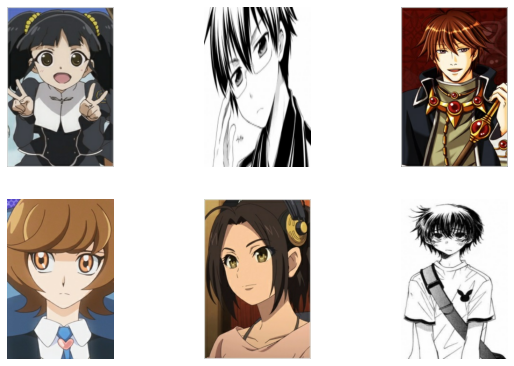

In [3]:
%%time

x_train = preprocessing.image_dataset_from_directory( 
  directory="./dataset/", 
  validation_split=0.4,
  subset='training',
  label_mode=None, 
  batch_size=BATCH_SIZE, 
  image_size=ORIGINAL_IMAGE_SIZE, 
  seed=123 , 
shuffle=True)

plt.figure(figsize=(10, 10))
plt.title("Training Images")
for images in x_train.take(1):
  print(images.shape)
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")


> Cashe Dataset

In [4]:
%%time
print("Wall time: 5min 22s")
d1_hist, d2_hist, g_hist = list(), list(), list()
# Cache keeps the images in memory after they're loaded off disk during the first epoch. 
# This will ensure the dataset does not become a bottleneck while training your model. 
# Prefetch overlaps data preprocessing and model execution while training.
# This allows later elements to be prepared while the current element is being processed. 
# This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.
def configure_for_performance(ds, name):
    ds = ds.cache(name)
    # ds = ds.shuffle(buffer_size=2000) # we are making shuffle at the loading
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

# normalized_ds = x_train.map(tf.keras.layers.Rescaling(scale=1./255)) # scale 0 to 1
normalized_ds = x_train.map(tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)) # scale -1 to 1 because we are using tanh
# Cashe, shuffle and prefetch the data
train_ds = configure_for_performance(normalized_ds, "./cache/training_cashe")

for image_batch in train_ds:
    print(image_batch.shape)
    print("In range between: ", np.min(image_batch[0])," and: ", np.max(image_batch[0]))
    break


Wall time: 5min 22s
(8, 360, 240, 3)
In range between:  0.023651963  and:  0.96549743
Wall time: 85.8 ms


## DCGAN 
> Generator

In [5]:
def generator_model():
    print("Generating DCGAN model.")
    model = tf.keras.Sequential()
    model.add(layers.Dense(45*30*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Reshape((45, 30, 256)))
    assert model.output_shape == (None, 45, 30, 256)  # Note: None is the batch size
    
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 45, 30, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 90, 60, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 180, 120, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 360, 240, 3)

    print("DCGAN model completed")
    return model

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Generating DCGAN model.
DCGAN model completed
(8, 360, 240, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 345600)            34560000  
                                                                 
 batch_normalization (BatchN  (None, 345600)           1382400   
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 345600)            0         
                                                                 
 reshape (Reshape)           (None, 45, 30, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 45, 30, 256)      1638400   
 nspose)                                                         
                                                           

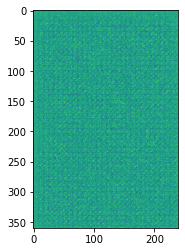

In [6]:
%%time

noise = tf.random.normal([BATCH_SIZE, noise_dim])
generator = generator_model()
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, 0]) # default RGB
generator.summary()

> Discriminator 

In [7]:
def discriminator_model():
    print("DCGAN descriminator model")
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                    input_shape=[360, 240, 3]))
    
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    print("DCGAN descriminator Completed!!")
    return model

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    d1_hist.append(real_loss)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    d2_hist.append(fake_loss)
    total_loss = real_loss + fake_loss
    return total_loss

In [8]:
discriminator = discriminator_model()
decision = discriminator(generated_image)
# print(decision)
discriminator.summary()

DCGAN descriminator model
DCGAN descriminator Completed!!
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 120, 64)      4864      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 180, 120, 64)      0         
                                                                 
 dropout (Dropout)           (None, 180, 120, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 60, 128)       204928    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 90, 60, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 90, 60, 128)       0         
                                                              

> Save Checkpoints

## Training DCGAN

### Training definitions 

In [9]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_images = generator(noise, training=True)
        # generated_images = ((generated_images +1)/2)*255
        # fig1 = plt.figure(figsize=(10, 10))
        # print(generated_images.shape)
        # print(generated_images.dtype)
        # print(generated_images)
        # for i in range(generated_images.shape[0]):
        #     plt.title('generated_images')
        #     plt.subplot(3, 3, i+1)
        #     plt.imshow(generated_images[i, :, :, 0] )
        #     plt.axis('off')
        # plt.savefig(new_images_root + 'generated_images_at_epoch_4.png')
        # plt.show()
        real_out = discriminator(images, training=True)
        # fig2 = plt.figure(figsize=(10, 10))
        # print(real_out.shape)
        # for i in range(real_out.shape[0]):
        #     plt.title('real_out')
        #     plt.subplot(3, 3, i+1)
        #     plt.imshow(real_out)
        #     plt.axis('off')
        # plt.savefig(new_images_root + 'Real_out_images_at_epoch_4.png')
        # plt.show()
        fake_out = discriminator(generated_images, training=True)
        # print(fake_out.shape)
        # fig2 = plt.figure(figsize=(10, 10))
        # print(fake_out.shape)
        # for i in range(fake_out.shape[0]):
        #     plt.title('fake_out')
        #     plt.subplot(3, 3, i+1)
        #     plt.imshow(fake_out)
        #     plt.axis('off')
        # plt.savefig(new_images_root + 'Fake_out_images_at_epoch_4.png')
        # plt.show()
        
        gen_loss = generator_loss(fake_out)
        g_hist.append(gen_loss)
        disc_loss = discriminator_loss(real_output=real_out, fake_output=fake_out)
        
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [10]:
def train(dataset, epochs):
    print("Training Start...")

    for epoch in range(0, epochs):
        print("Epoch :", epoch)
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 5 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        winsound.Beep(frequency=1000, duration=500 )
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    # plot_history(d1_hist, d2_hist, g_hist)


### Save and plot images

In [11]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    predictions = ((predictions + 1) /2)*255
    fig = plt.figure(figsize=(10, 10))
    
    for i in range(predictions.shape[0]):
        plt.subplot(3, 3, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5 )
        plt.axis('off')

    plt.savefig(new_images_root + 'image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

### Optimizer and Checkpoint 

In [12]:
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

checkpoint_dir = training_checkpoints_root
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator)

> Actual Train

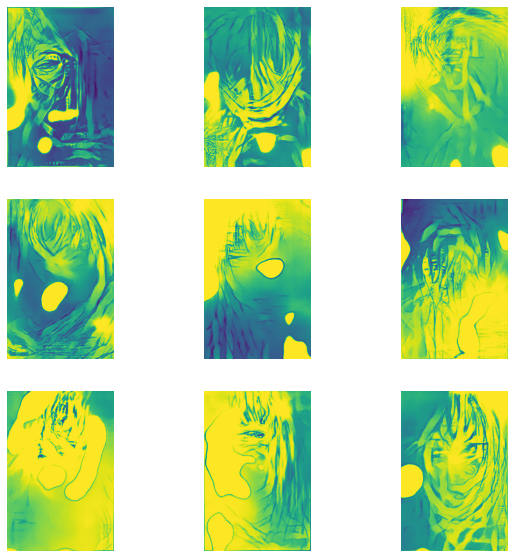

Time for epoch 20 is 1901.7760038375854 sec
Epoch : 20


KeyboardInterrupt: 

In [13]:
%%time
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
train(dataset=train_ds, epochs=EPOCHS)

winsound.PlaySound(sound=the_creation, flags=winsound.SND_ALIAS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

 ## Create a GIF

In [ ]:
%%time
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open(new_images_root + 'image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)


In [14]:
anim_file = 'anime_tut_dcgan1.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob(new_images_root + 'image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


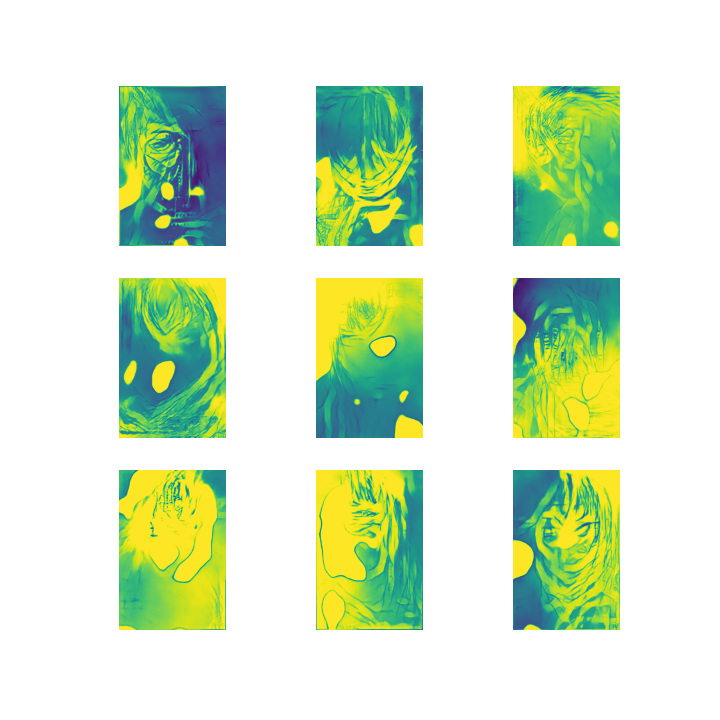

In [15]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)